In [3]:
from ultralytics import YOLO
import cv2
from PIL import Image
import numpy as np
from datetime import datetime
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch

C:\Users\2411c\anaconda3\envs\mini\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model=YOLO("../model/number_plate_detect/best.pt")


In [9]:
def get_plate(images):
    
    results=model.predict(images,show_boxes=True,save=False,conf=0.25)
    rs=[]
    for result in results:
        for box in result.boxes:
            left, top, right, bottom = np.array(box.xyxy.cpu(), dtype=np.int32).squeeze()
            region=result.orig_img[top: bottom,left:right]
            now=datetime.now()
            filename="results/result"+str(now.strftime("%Y%m%d%H%M%S"))+"_"+str(len(rs))+".png"
            print(filename)
            cv2.imwrite(filename,region)
            
            rs.append(filename)

    return rs

In [10]:
r=get_plate("college_data/")


image 1/120 C:\Users\2411c\Desktop\mini\testing\college_data\IMG-20240806-WA0002.jpg: 256x320 1 Plate, 106.7ms
image 2/120 C:\Users\2411c\Desktop\mini\testing\college_data\IMG-20240806-WA0003.jpg: 256x320 1 Plate, 66.8ms
image 3/120 C:\Users\2411c\Desktop\mini\testing\college_data\IMG-20240806-WA0004.jpg: 256x320 2 Plates, 55.9ms
image 4/120 C:\Users\2411c\Desktop\mini\testing\college_data\IMG-20240806-WA0005.jpg: 256x320 1 Plate, 57.0ms
image 5/120 C:\Users\2411c\Desktop\mini\testing\college_data\IMG-20240806-WA0006.jpg: 256x320 1 Plate, 58.0ms
image 6/120 C:\Users\2411c\Desktop\mini\testing\college_data\IMG-20240806-WA0007.jpg: 256x320 2 Plates, 58.5ms
image 7/120 C:\Users\2411c\Desktop\mini\testing\college_data\IMG-20240806-WA0008.jpg: 256x320 1 Plate, 58.0ms
image 8/120 C:\Users\2411c\Desktop\mini\testing\college_data\IMG-20240806-WA0009.jpg: 256x320 3 Plates, 64.0ms
image 9/120 C:\Users\2411c\Desktop\mini\testing\college_data\IMG-20240806-WA0010.jpg: 256x320 1 Plate, 58.1ms
image

In [6]:
import torch_directml

In [4]:
ocr_model =  VisionEncoderDecoderModel.from_pretrained("../model/vit_ocr/trocr-small-pretrained")
processor = TrOCRProcessor.from_pretrained("../model/vit_ocr/trocr-small-pretrained")

In [57]:
image = cv2.imread(r[1])
h,w,d=image.shape
h,w,d

(341, 496, 3)

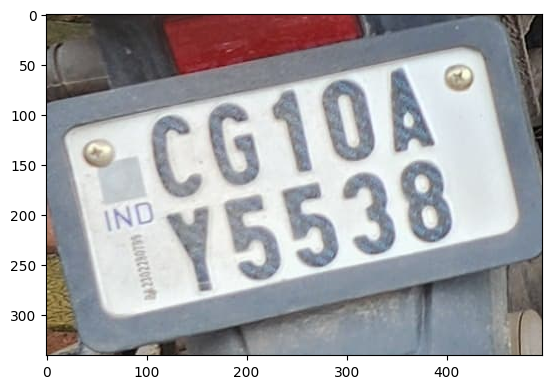

In [58]:
plt.imshow(cv2.cvtColor(image,cv2.COLOR_RGB2BGR))

In [59]:
print(h,w)

341 496


In [60]:
w/h
img1=image[0:int(h/2)]
img2=image[int(h/2):]
img = cv2.hconcat([img1, img2])

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matrix_operations.cpp:67: error: (-215:Assertion failed) src[i].dims <= 2 && src[i].rows == src[0].rows && src[i].type() == src[0].type() in function 'cv::hconcat'


In [64]:
img1.shape

(170, 496, 3)

In [66]:
img2.shape

(171, 496, 3)

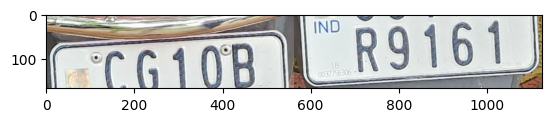

In [75]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))

In [149]:
def preprocess_image(imageg, is_bike):
    

    # Convert to HSV
    image = cv2.resize(imageg, (1024, 256))
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply thresholding on the Value channel
    h, s, v = cv2.split(hsv)
    thresh = cv2.adaptiveThreshold(v, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    
    plt.imshow(cv2.cvtColor(thresh,cv2.COLOR_RGB2BGR))
    plt.show()
    if is_bike:
        # Split the image horizontally
        height = thresh.shape[0]
        upper_half = thresh[:height // 2, :]
        lower_half = thresh[height // 2:, :]

        # Concatenate the halves vertically
        combined = cv2.vconcat([upper_half, lower_half])

        # Convert back to 3 channels by combining with H and S channels
        combined_colored = cv2.merge((h, s, combined))
        processed_image = cv2.cvtColor(combined_colored, cv2.COLOR_HSV2BGR)
    else:
        # Convert back to 3 channels by combining with H and S channels
        thresh_colored = cv2.merge((h, s, thresh))
        processed_image = cv2.cvtColor(thresh_colored, cv2.COLOR_HSV2BGR)

    # Resize image to expected input size
    resized = cv2.resize(processed_image, (1024, 256))

    return resized


def extract_text(file):

    image = cv2.imread(file)
    h,w=image.shape[:2]
    if w/h<1.5:
    #     l=int(h/2)
    #     img1=image[0:l]
    #     img2=image[-l:]
    #     img = cv2.hconcat([img1, img2])

        image = preprocess_image(img,True)
        plt.imshow(cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
        plt.show()
        pixel_values = processor(image, return_tensors="pt").pixel_values
        
        del image
    else:
        pixel_values = processor(image, return_tensors="pt").pixel_values
    
    
    
    
    
    if torch.cuda.is_available():#NVIDIA GPU
        device = torch.device("cuda:0")
    elif torch_directml.device():#FOR AMD GPU
        device=torch_directml.device()
    else:#FOR CPU
        device=torch.device("cpu")
    
        
    pixel_values = pixel_values.to(device)
    ocr_model.to(device)
    
    generated_ids = ocr_model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    number_plate=""
    for ch in generated_text:
        if ch.isalnum():
            number_plate+=ch
    print(number_plate)
    return number_plate

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline

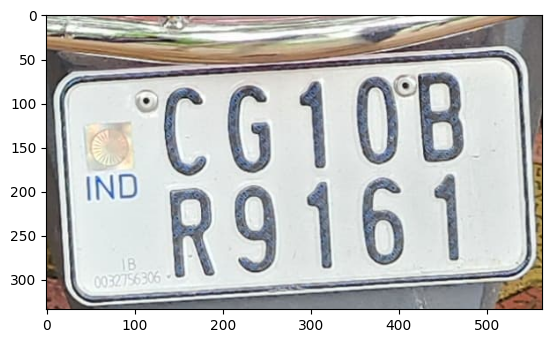

167
334


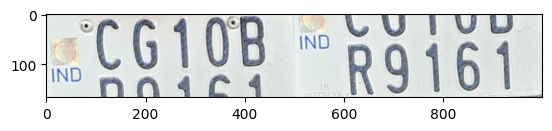

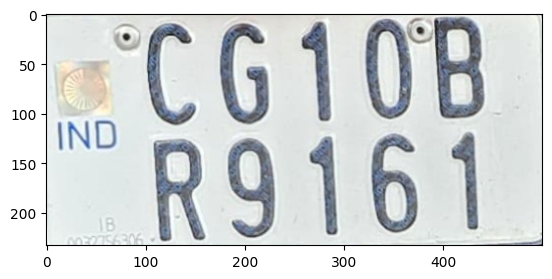

CG10BR9161


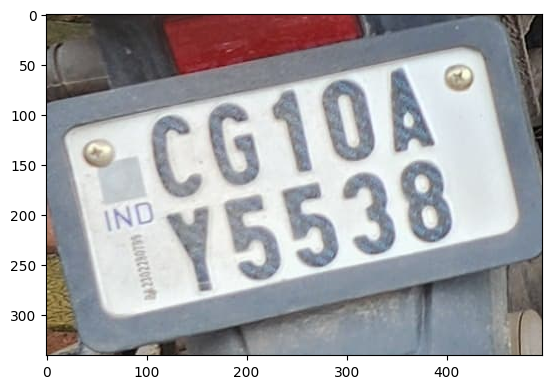

170
341


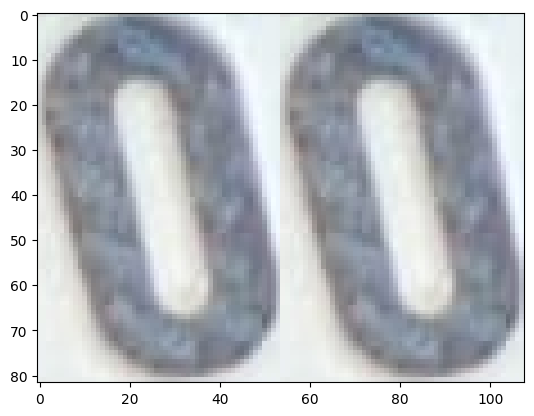

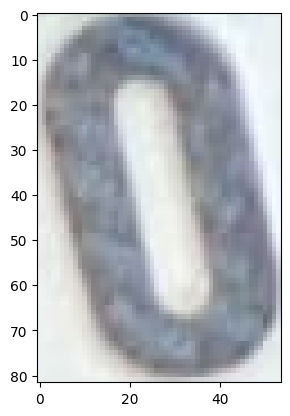

00


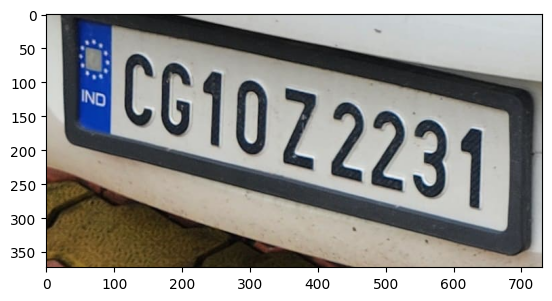

0010722331


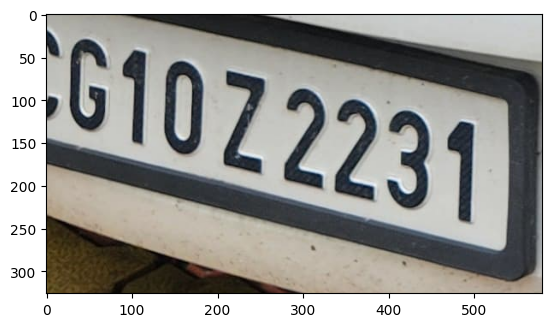

163
326


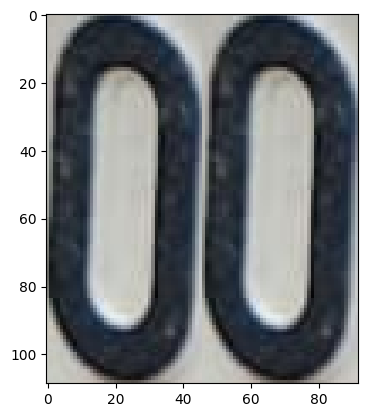

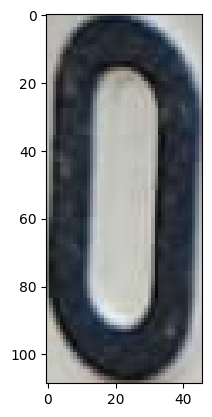

00


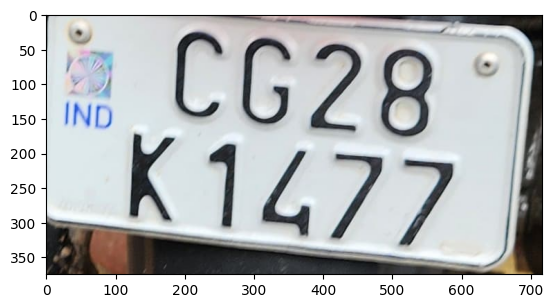

GST


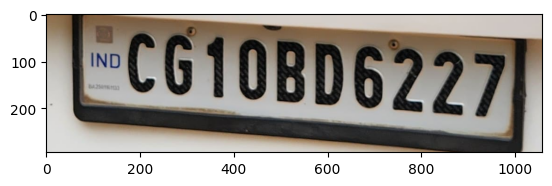

CG10BD6227


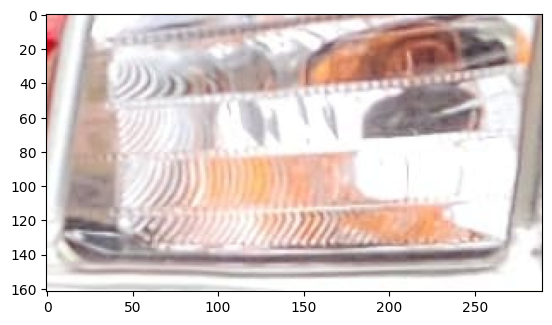

81
162


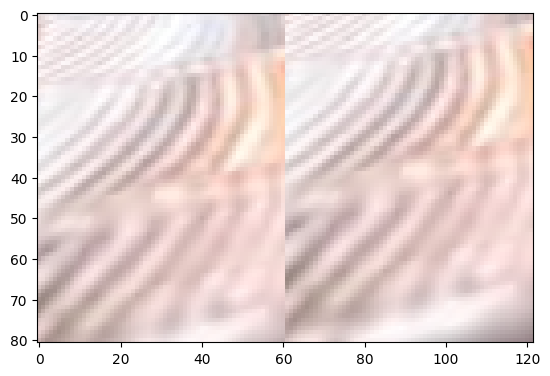

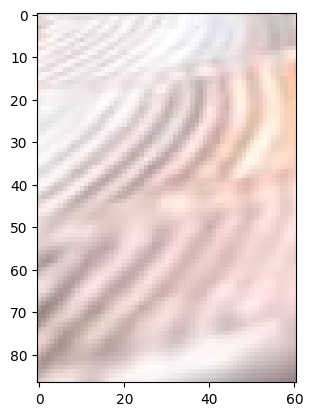

2


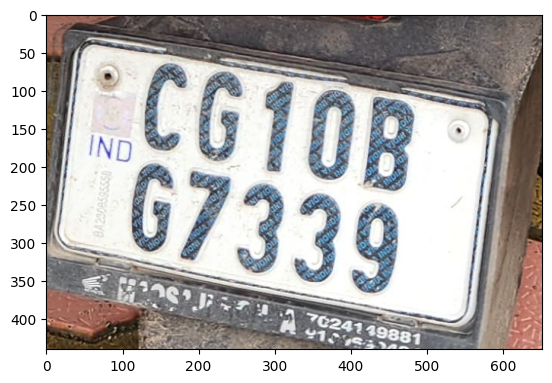

220
440


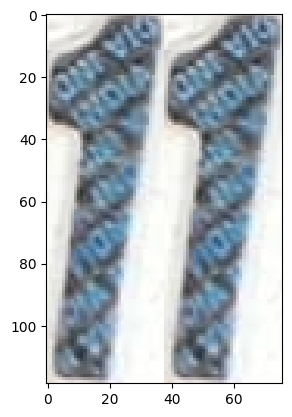

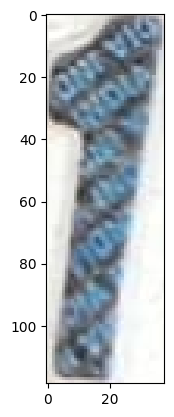

11


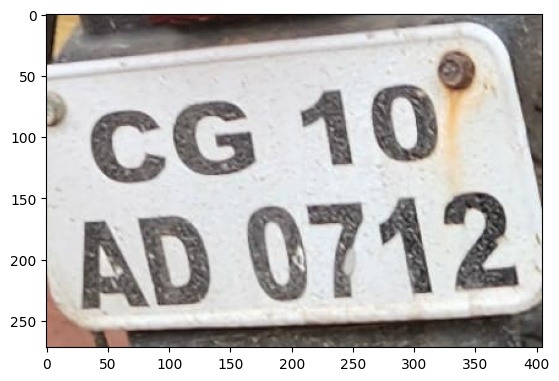

136
272


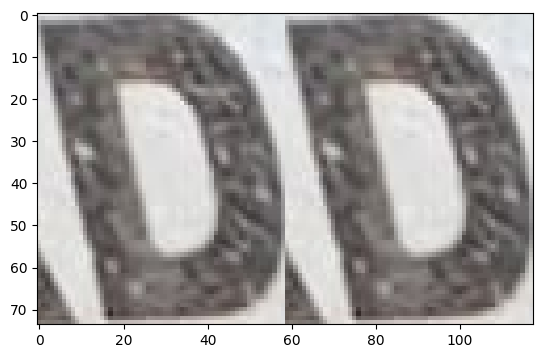

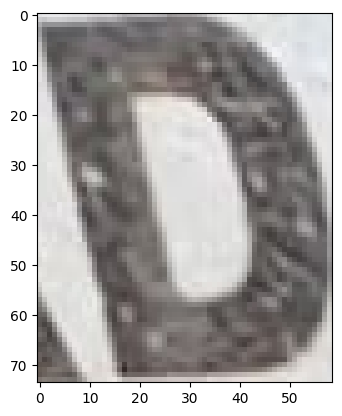

OD


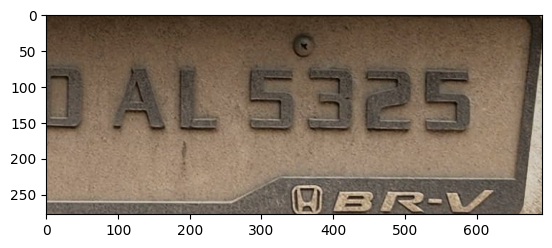

JAL5325


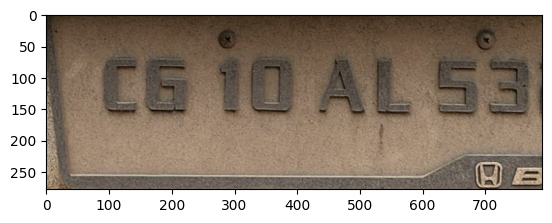

CSIDAL5A


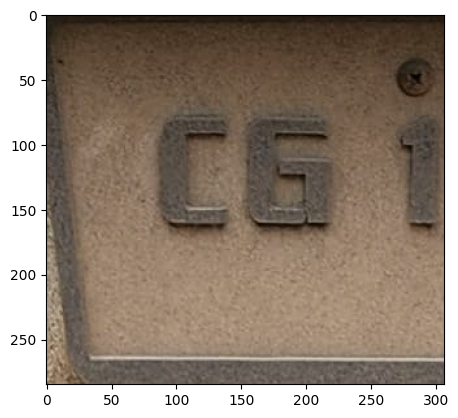

142
285


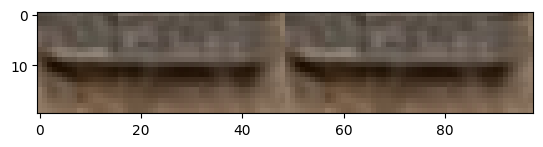

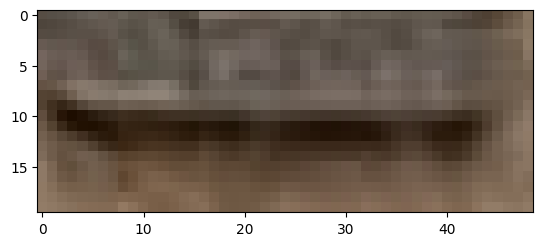

SEEBACKOFRECEIPT


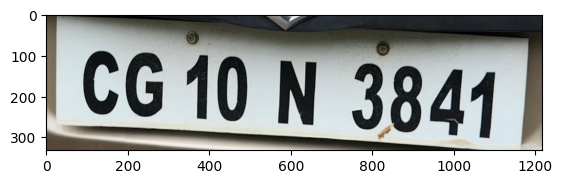

CG10N3841


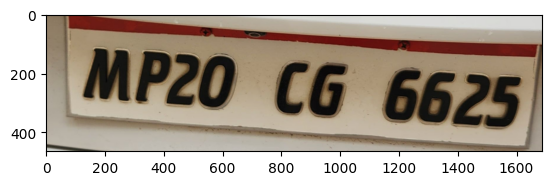

MP2066625


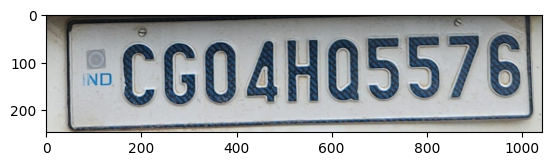

CGO4H05576


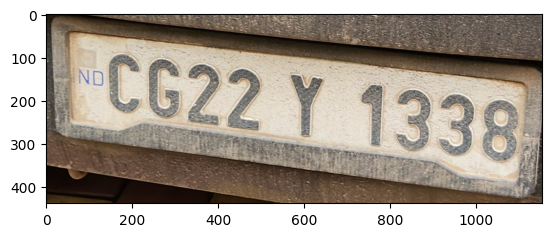

BEAVES


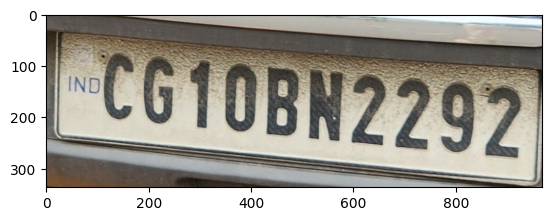

C610BN2292


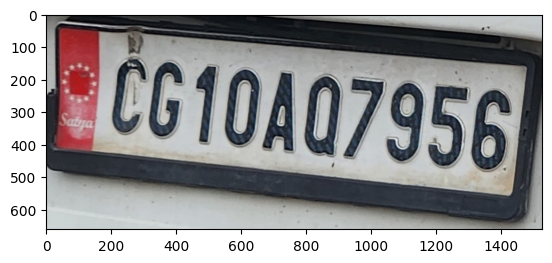

REG10A07956


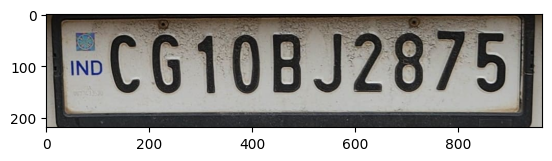

CG10BJ2875


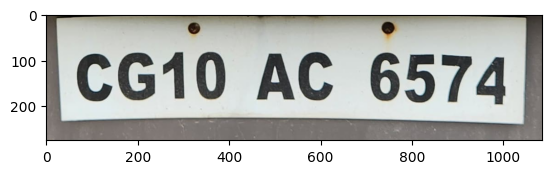

CG10AC6574


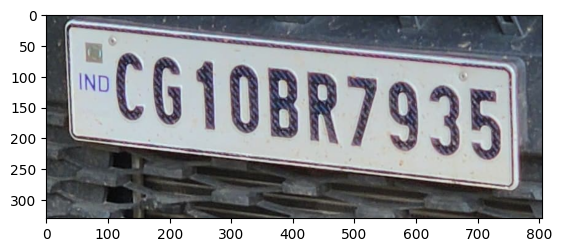

POSTINGRECEIPT


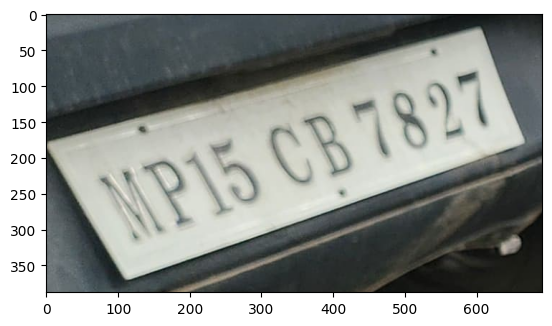

194
388


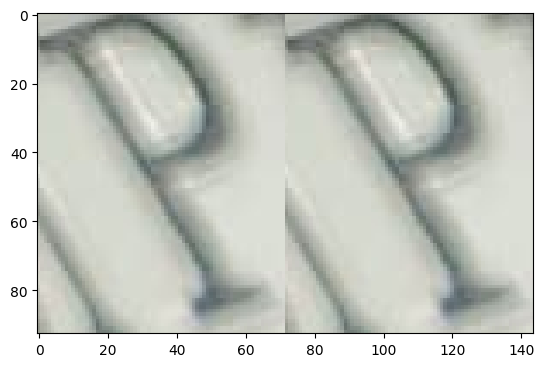

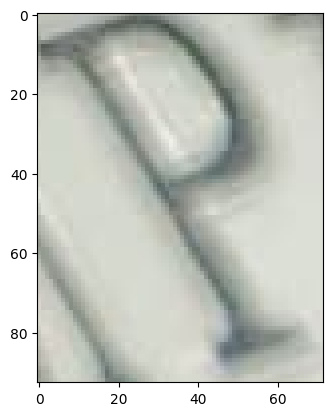

PR


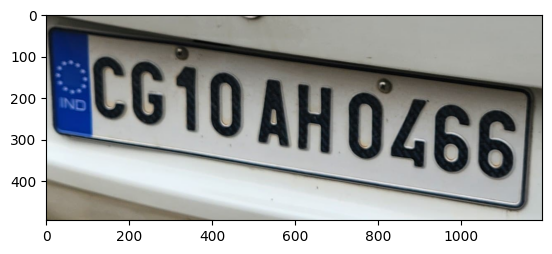

REG10AH0656


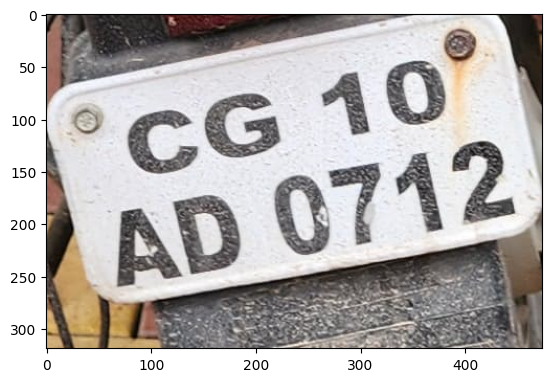

159
319


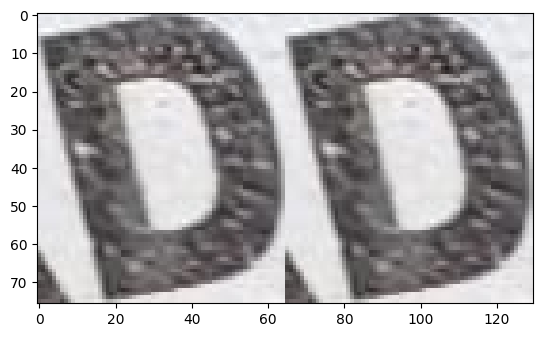

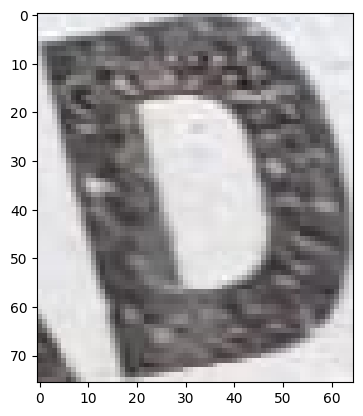

00


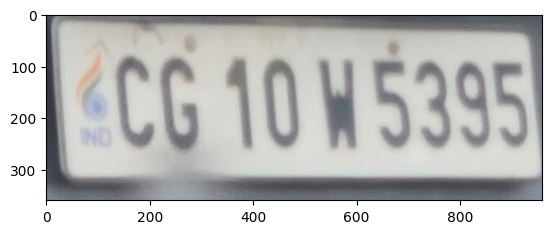

CG10W5395


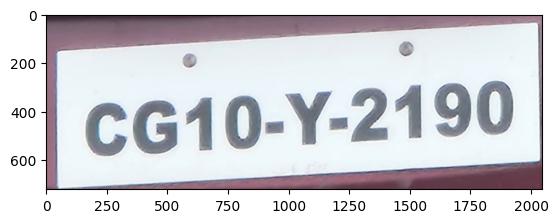

CG10Y2190


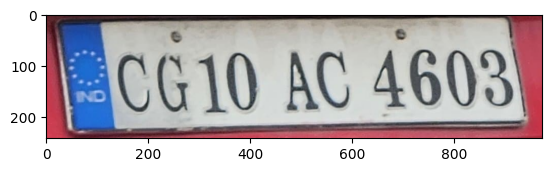

CGLIOAC4603


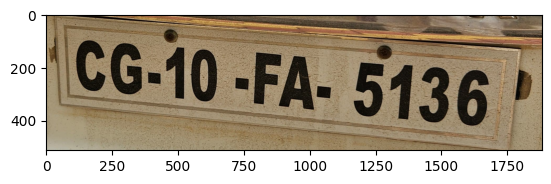

ICG10FA5136


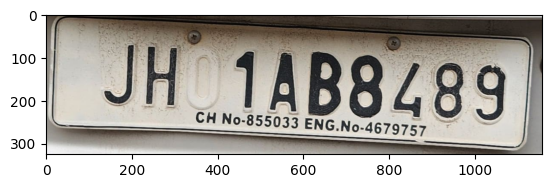

JH1AB8489


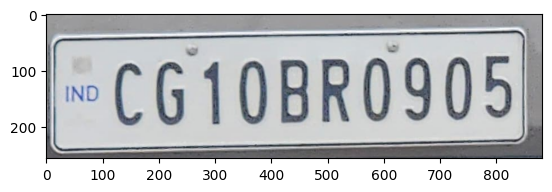

CG10BR0905


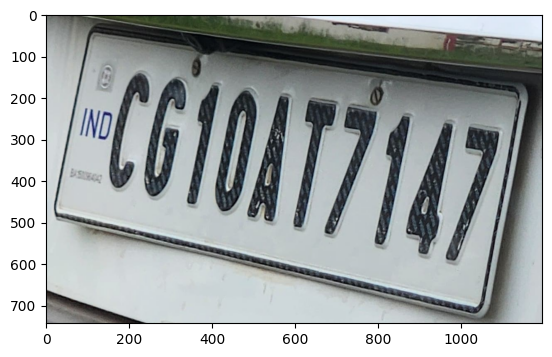

371
743


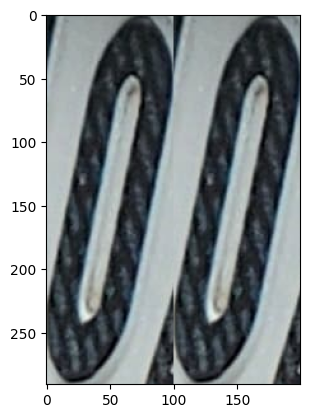

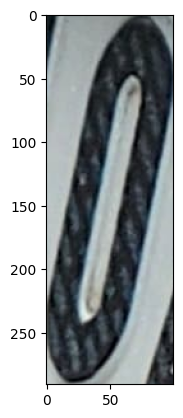

00


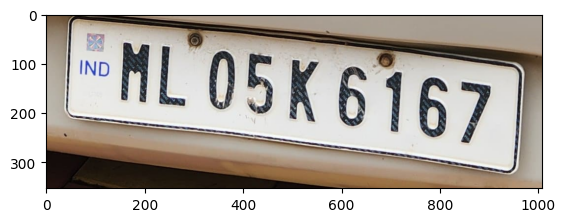

RM05K6167


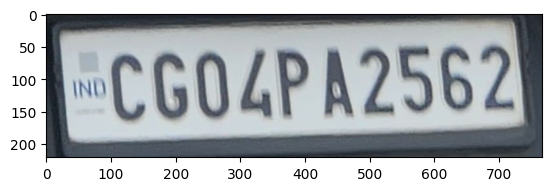

CGO4PA2562


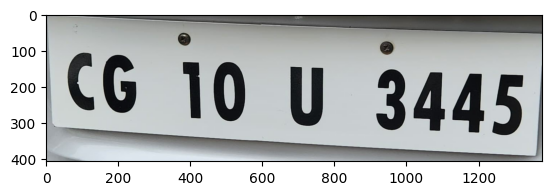

CG10U3445


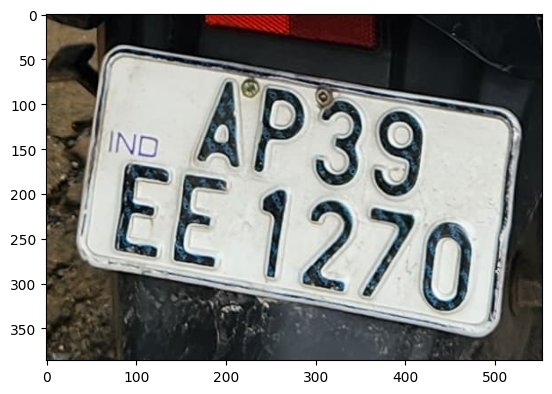

193
386


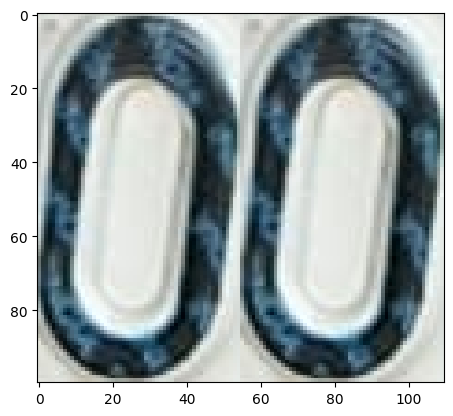

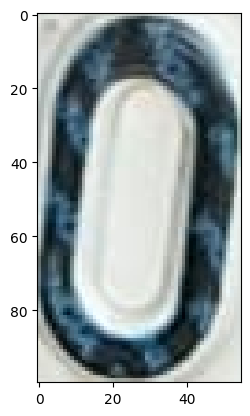

00


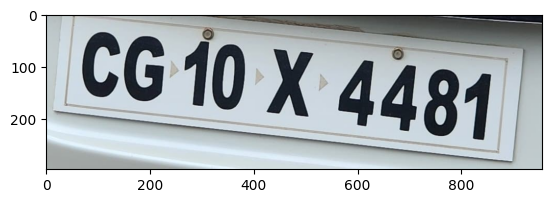

CG10X4481


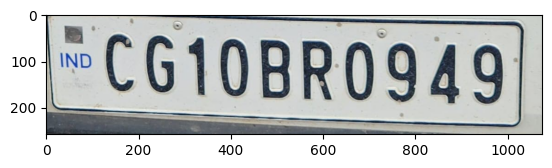

CG10BR0949


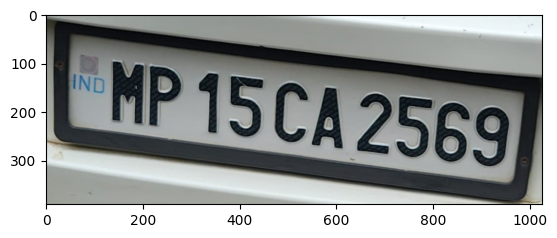

MP15CA2569


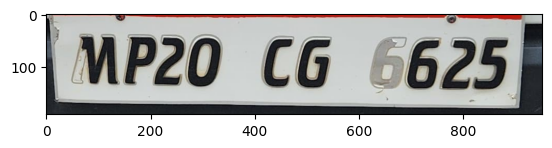

MP20C66625


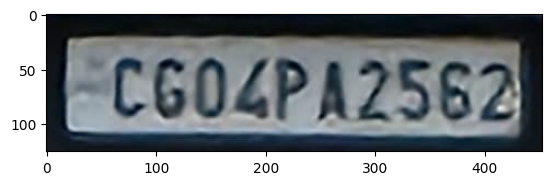

CG04PA2562


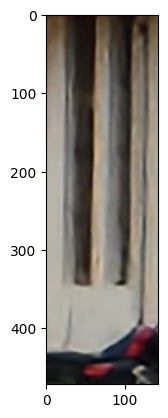

236
472


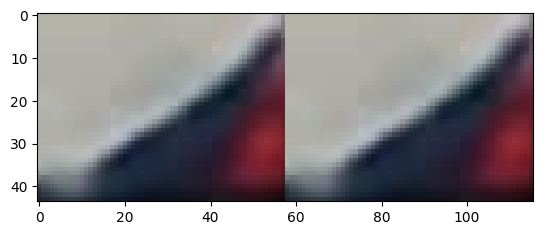

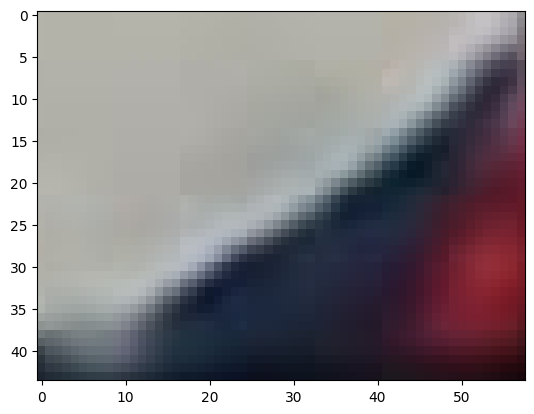

44


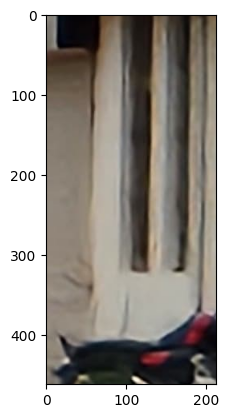

231
462


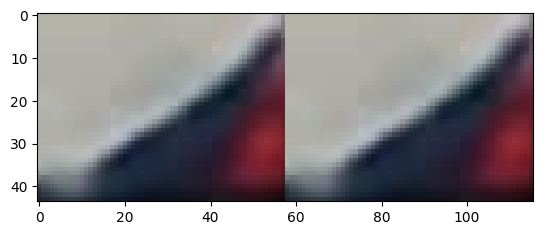

KeyboardInterrupt: 

In [181]:
time=datetime.now()
number_plates=[]
for n in r:
    im=cv2.imread(n)
    
    plt.imshow(cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
    plt.show()
    number_plates.append(extract_text(n))
print(datetime.now()-time)

In [174]:
import numpy as np

167
334


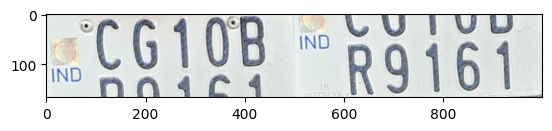

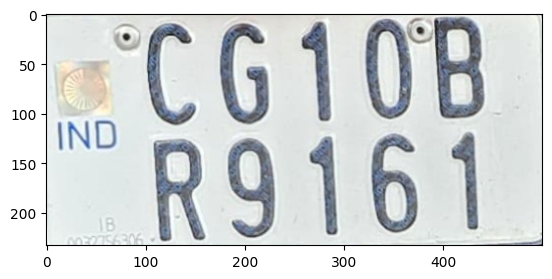

CG10BR9161


'CG10BR9161'

In [180]:


# Load the model and processor
# processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
# ocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')
def bike(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use Canny edge detection
    edges = cv2.Canny(gray, 50, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the number plate is the largest rectangle contour
    number_plate_contour = max(contours, key=cv2.contourArea)

    # Approximate the contour to a polygon
    epsilon = 0.02 * cv2.arcLength(number_plate_contour, True)
    approx = cv2.approxPolyDP(number_plate_contour, epsilon, True)

    if len(approx) == 4:  # Check if the contour is a quadrilateral
        # Get the coordinates of the quadrilateral
        pts = approx.reshape(4, 2)
        
        # Sort the points to get top-left, top-right, bottom-right, bottom-left
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        # Get the top-left, top-right, bottom-right, bottom-left points
        (tl, tr, br, bl) = rect

        # Compute the width and height of the new image
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        # Set up the destination points for the transform
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype="float32")

        # Compute the perspective transform matrix and apply it
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
        
        # Convert the warped image to RGB
        cropped_image_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
        
    else:
        # If the contour is not a quadrilateral, fall back to bounding rectangle
        x, y, w, h = cv2.boundingRect(number_plate_contour)
        cropped_image = image[y:y+h, x:x+w]
        cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    return cropped_image_rgb
def extract_text(img_path):
    # Load the image
    image = cv2.imread(img_path)
    
    h,w=image.shape[:2]
    if w/h<1.9:
        l=h//2
        print(l)
        print(h)
        cropped_image_rgb=bike(image)
        img1=cropped_image_rgb[0:l]
        img2=cropped_image_rgb[-l:]
        img = cv2.hconcat([img1, img2])
        plt.imshow(img)
        plt.show()
    
        plt.imshow(cropped_image_rgb)
        plt.show()
    else:
        img=image
    # Convert the image to a tensor
    pixel_values = processor(images=img, return_tensors="pt").pixel_values

    # Move the tensor to the appropriate device
    if torch.cuda.is_available():  # NVIDIA GPU
        device = torch.device("cuda:0")
    elif hasattr(torch_directml, 'device'):  # FOR AMD GPU
        device = torch_directml.device()
    else:  # FOR CPU
        device = torch.device("cpu")

    pixel_values = pixel_values.to(device)
    ocr_model.to(device)

    # Perform OCR
    generated_ids = ocr_model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Extract alphanumeric characters
    number_plate = "".join(ch for ch in generated_text if ch.isalnum())

    print(number_plate)
    return number_plate

# Path to the image
img_path = '/mnt/data/result20240806141301_7.png'

# Extract text from the image
extract_text(r[0])


In [178]:
74/128
a

NameError: name 'a' is not defined

In [29]:
import pandas as pd

In [31]:
df=pd.DataFrame(columns=['image_file','Actual_RC','Detected_RC'])


In [39]:
for file,detected in zip(r,number_plates):
    df.loc[len(df.index)] = [file,'',detected]

In [ ]:
for file in zip(r,number_plates):
    filename=file[0][:-3]+'txt'
    with open(filename) as f:
        f.write()
    

In [40]:
df

image_file Actual_RC Detected_RC
0      results/result20240806141301_0.png                   REF
1      results/result20240806141301_1.png                  THAN
2      results/result20240806141301_2.png            0010722331
3      results/result20240806141301_3.png              10722231
4      results/result20240806141301_4.png                   GST
..                                    ...       ...         ...
124  results/result20240806141304_124.png             CG10Y3148
125  results/result20240806141304_125.png                      
126  results/result20240806141304_126.png             CG10S6709
127  results/result20240806141304_127.png            CG15CP4050
128  results/result20240806141304_128.png               SECTION

[129 rows x 3 columns]

In [38]:
df.add(['as','ad','dad'])

Empty DataFrame
Columns: [image_file, Actual_RC, Detected_RC]
Index: []

In [42]:
df.to_excel('result.xlsx',index=False)

In [128]:
def preprocess_image(img_path):
    image = cv2.imread(img_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Convert back to 3 channels
    thresh_colored = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

    # Resize image to expected input size
    resized = cv2.resize(thresh_colored, (1024, 256))

    return resized

def extract_text(img_path):
    image = preprocess_image(img_path)
    plt.imshow(image)
    plt.show()
    pixel_values = processor(image, return_tensors="pt").pixel_values

    if torch.cuda.is_available():  # NVIDIA GPU
        device = torch.device("cuda:0")
    elif torch_directml.device():  # FOR AMD GPU
        device = torch_directml.device()
    else:  # FOR CPU
        device = torch.device("cpu")
    
    pixel_values = pixel_values.to(device)
    ocr_model.to(device)
    
    generated_ids = ocr_model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    number_plate = ""
    for ch in generated_text:
        if ch.isalnum():
            number_plate += ch
    
    print(number_plate)
    return number_plate

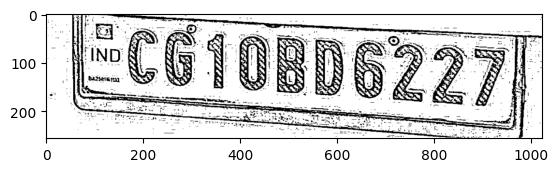

CG10806227


'CG10806227'

In [132]:
extract_text(r[5])